![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 4 - Deep Learning Basics</center>
### <center> Stochastic Gradient Descent (SGD)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/04_OptimizationMethods/MainSGD1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/04_OptimizationMethods/SGD_ExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- What we have so far:
from SGD_ExampleAux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Accuracy

### Get Fashion MNIST dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
mX.shape, vY.shape, lClasses

((60000, 784),
 (60000,),
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

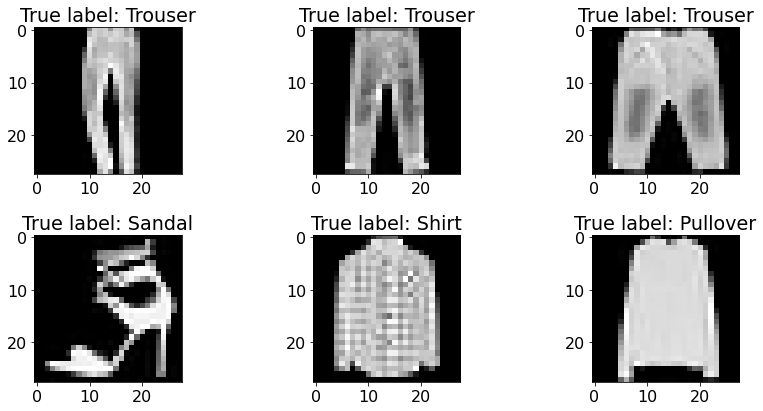

In [7]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vY[idx]]))
    
plt.tight_layout()
plt.show()

###  Normalize data:

In [8]:
vMean = np.mean(mX, axis=0)
vStd  = np.std (mX, axis=0)
mX    = (mX - vMean) / vStd

###  Split to train and validation:

In [9]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((55000, 784), (55000,), (5000, 784), (5000,))

### Define a dataset (data loader) class:

In [10]:
class Dataset:
    def __init__(self, mX, vY, batchSize):
        self.mX             = mX
        self.vY             = vY
        self.N              = len(vY)
        self.batchSize      = min(batchSize, self.N)
        self.numMiniBatches = self.N // self.batchSize
            
    def __len__(self):
        return self.numMiniBatches
    
    #-- Return mini-batches:
    def __iter__(self):
        vIdx = np.random.permutation(self.N)
    
        for ii in range(self.numMiniBatches):
            startIdx  = ii * self.batchSize
            vBatchIdx = vIdx[startIdx : startIdx + self.batchSize]
            mBatchX   = self.mX[:,vBatchIdx]
            vBatchY   = self.vY[vBatchIdx]

            yield mBatchX, vBatchY

### Construct train and validation data loaders:

In [11]:
batchSize = 2048
oTrainSet = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet   = Dataset(mValX.T,   vValY,  batchSize)

### Define the training loop with mini-batches:

In [12]:
import time

def TrainLoop(oModel, oTrainData, learningRate):
    
    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanilla gradient descnet):
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
                
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:.6f}', end='')
    
    print('', end='\r')
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData):
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
    
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

### Qeustion:
Why do we use mini-batches in `ValidationLoop` as well?

### Train model function:

In [13]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, learningRate)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        #-- Display:
        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')


### Train a shallow model (with mini-batches):

In [14]:
oModel = SequentialModel([
        LinearLayer(784, 200),
        ReLULayer(),
        LinearLayer(200, 10),
])

TrainModel(oModel, oTrainSet, oValSet, 10, 5e-2)

Epoch   0: | Train loss: 1.04938 | Val loss: 0.70037 | Train Accuracy: 0.6519 | Val Accuracy: 0.7629 | epoch time: 1.304 |
Epoch   1: | Train loss: 0.64081 | Val loss: 0.59403 | Train Accuracy: 0.7799 | Val Accuracy: 0.7949 | epoch time: 1.382 |
Epoch   2: | Train loss: 0.56523 | Val loss: 0.54061 | Train Accuracy: 0.8043 | Val Accuracy: 0.8064 | epoch time: 1.366 |
Epoch   3: | Train loss: 0.52256 | Val loss: 0.51396 | Train Accuracy: 0.8176 | Val Accuracy: 0.8210 | epoch time: 1.333 |
Epoch   4: | Train loss: 0.49468 | Val loss: 0.48602 | Train Accuracy: 0.8271 | Val Accuracy: 0.8335 | epoch time: 1.357 |
Epoch   5: | Train loss: 0.47402 | Val loss: 0.47569 | Train Accuracy: 0.8350 | Val Accuracy: 0.8354 | epoch time: 1.371 |
Epoch   6: | Train loss: 0.45794 | Val loss: 0.46001 | Train Accuracy: 0.8398 | Val Accuracy: 0.8435 | epoch time: 1.373 |
Epoch   7: | Train loss: 0.44560 | Val loss: 0.43377 | Train Accuracy: 0.8445 | Val Accuracy: 0.8503 | epoch time: 1.365 |
Epoch   8: | Tra

### Add figures to training loop:

In [15]:
class Plot:
    def __init__(self, sTitle, sLabel, sXlabel, sColor, vData=[]):
        self.sTitle  = sTitle
        self.sLabel  = sLabel
        self.sXlabel = sXlabel
        self.sColor  = sColor
        self.vData   = vData

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Recorder:
    def __init__(self, lPlots, figsize=(12,4)):
        self.lTitles = np.unique([oPlot.sTitle for oPlot in lPlots])
        self.N       = len(self.lTitles)
        self.fig, _  = plt.subplots(1, self.N, figsize=(12, 4))
        self.dAxes   = {}
        ii           = 0
        for oPlot in lPlots:
            ax = self.dAxes.get(oPlot.sTitle, None)
            if ax == None:
                ax                       = self.fig.axes[ii]
                ii                      += 1
                self.dAxes[oPlot.sTitle] = ax

            ax.set_title(oPlot.sTitle)
            ax.set_xlabel(oPlot.sXlabel)
            ax.plot(oPlot.vData, c=oPlot.sColor, label=oPlot.sLabel)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()

    def Append(self, sTitle, sLabel, vData):
        ax = self.dAxes[sTitle]
        for oLine in ax.lines:
            if oLine.get_label() == sLabel:
                vYdata = np.append(oLine.get_ydata(), vData)
                N      = len(vYdata)
                oLine.set_data(list(range(N)), vYdata)
        lYlim = ax.axis()[2:4]
        if N > 1:
            ax.axis(xmin=0, xmax=N, ymin=np.minimum(np.min(vData), lYlim[0]), ymax=np.maximum(np.max(vData), lYlim[1]))
        else:
            ax.axis(xmin=0, xmax=N, ymin=np.min(vData), ymax=np.max(vData)+1e-10)
            
    def Get(self, sTitle, sLabel):
        ax = self.dAxes[sTitle]
        for oLine in ax.lines:
            if oLine.get_label() == sLabel:
                return oLine.get_ydata()

    def Draw(self):
        self.fig.canvas.draw()
        plt.pause(1e-10)

### Train model function (with figures):

In [16]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
   
    #-- Set the plots:
    oRecorder = Recorder([
        Plot('Loss',       'train', 'epoch', 'b'),
        Plot('Loss',       'val',   'epoch', 'r'),
        Plot('Accuracy',   'train', 'epoch', 'b'),
        Plot('Accuracy',   'val',   'epoch', 'r'),
    ])

    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, learningRate)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('Accuracy', 'train', trainAcc),
        oRecorder.Append('Accuracy', 'val',   valAcc),
        oRecorder.Draw()
        
        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')
        

<IPython.core.display.Javascript object>


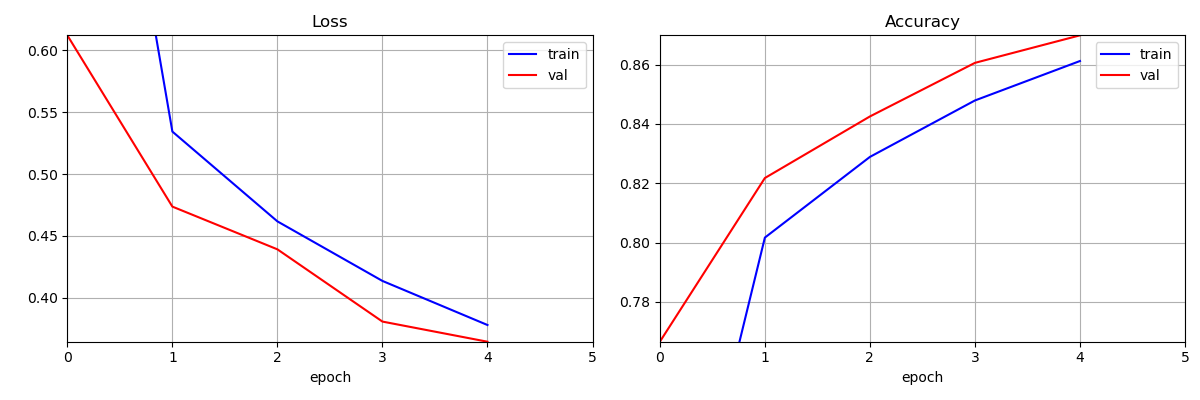

Epoch   0: | Train loss: 1.02787 | Val loss: 0.61214 | Train Accuracy: 0.6566 | Val Accuracy: 0.7666 | epoch time: 4.303 |
Epoch   1: | Train loss: 0.53433 | Val loss: 0.47368 | Train Accuracy: 0.8017 | Val Accuracy: 0.8218 | epoch time: 4.228 |
Epoch   2: | Train loss: 0.46174 | Val loss: 0.43913 | Train Accuracy: 0.8289 | Val Accuracy: 0.8425 | epoch time: 4.282 |
Epoch   3: | Train loss: 0.41359 | Val loss: 0.38073 | Train Accuracy: 0.8479 | Val Accuracy: 0.8606 | epoch time: 4.359 |
Epoch   4: | Train loss: 0.37796 | Val loss: 0.36445 | Train Accuracy: 0.8612 | Val Accuracy: 0.8699 | epoch time: 4.387 |
Iteration:  18: loss = 0.353763

In [ ]:
%matplotlib notebook

oModel = SequentialModel([
        LinearLayer(784, 500),
        ReLULayer(),
        LinearLayer(500, 250),
        ReLULayer(),
        LinearLayer(250, 150),
        ReLULayer(),
        LinearLayer(150, 100),
        ReLULayer(),
        LinearLayer(100,  10),
])

TrainModel(oModel, oTrainSet, oValSet, 20, 2e-1)

### Apply model to test data:

In [ ]:
%matplotlib inline

oTorchTestSet = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
mTestX        = oTorchTestSet.data.view(-1,784).numpy() / 255
mTestX        = (mTestX - vMean) / vStd
vTestY        = oTorchTestSet.targets.numpy()

#-- Apply model to data:
mHatTestY = oModel.Forward(mTestX.T)
print('Test accuracy:' + str(100 * Accuracy(mHatTestY, vTestY)) + '%')

#-- Plot a few mistakes:
vHatTestY = np.argmax(mHatTestY, axis=0)
vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(8,6))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow(np.reshape(mTestX[idx,:] * vStd + vMean, (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vTestY[idx]]) + '\nEstimated label: ' + str(lClasses[vHatTestY[idx]]))
    
plt.tight_layout()
plt.show()